from google.colab import drive
drive.mount('/content/drive')

In [160]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np

import keras
import tensorflow
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

!pip install -q -U keras-tuner
import kerastuner as kt

from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import re

from nltk import pos_tag
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer 

from imblearn.over_sampling import SMOTE

from IPython.display import display 

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
import sys
sys.path.append("../..")


from src.model_evaluation import *
from src.data_preprocessing import *

sns.set(context = 'notebook', style = 'whitegrid')
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\caell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\caell\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\caell\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data Preprocessing 

df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/flatiron_project_4/judge-1377884607_tweet_product_company.csv',
            encoding = 'latin1')
lem = True
df.columns = ['text', 'product', 'emotion']
df = df[df['emotion'] != 'I can\'t tell']
df.dropna(inplace = True)
df['text_product'] = df.apply(lambda x: list([x['text'], x['product']]), axis = 1)
df['emotion'] = df['emotion'].map(emotion_label)
df['txt_cleaned'] = df['text_product'].apply(txt_clean, args = (lem,))
df.drop(columns = ['text', 'product', 'text_product'], inplace = True)

In [161]:
sequence_len = 128
df = df_clean()
X = df['txt_cleaned']
y = df['emotion']

# binarizer = LabelBinarizer()
# y = pd.DataFrame(binarizer.fit_transform(y), columns = binarizer.classes_)
encoder = LabelEncoder()
tokenizer = text.Tokenizer()
sm = SMOTE()

#Encode Labels
y = pd.DataFrame(encoder.fit_transform(y))

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.25)

#tokenize full X_train
tokenizer.fit_on_texts(list(X_train))
list_tokenized_headlines = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(list_tokenized_headlines, maxlen=100)

#Tokenize training X
tokenized_X_t = tokenizer.texts_to_sequences(X_t)
X_t = sequence.pad_sequences(tokenized_X_t, maxlen=128)

#Tokenize validation
tokenized_X_val = tokenizer.texts_to_sequences(X_val)
X_val = sequence.pad_sequences(tokenized_X_val, maxlen=128)

#Tokenize hold out set
tokenized_X_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_X_test, maxlen=128)

#Create SMOTE'd version of X_t
X_t_res, y_t_res = sm.fit_sample(X_t,y_t)


## Model 1
RNN First Simple Model, no SMOTE

In [19]:
def make_model1():
    embedding_size = 128
    model1 = Sequential()
    model1.add(Embedding(len(tokenizer.word_index.keys())+1, sequence_len))
    model1.add(LSTM(25, return_sequences=True))
    model1.add(GlobalMaxPool1D())
    model1.add(Dropout(0.5))
    model1.add(Dense(50, activation='relu'))
    model1.add(Dropout(0.5))
    model1.add(Dense(3, activation='softmax'))

    model1.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model1

Epoch 1/11
37/37 [==============================] - 1s 23ms/step - loss: 0.7284 - acc: 0.7843 - val_loss: 0.5529 - val_acc: 0.8182
Epoch 2/11
37/37 [==============================] - 0s 13ms/step - loss: 0.6225 - acc: 0.8103 - val_loss: 0.5439 - val_acc: 0.8182
Epoch 3/11
37/37 [==============================] - 0s 13ms/step - loss: 0.6076 - acc: 0.8108 - val_loss: 0.5387 - val_acc: 0.8182
Epoch 4/11
37/37 [==============================] - 0s 13ms/step - loss: 0.5910 - acc: 0.8108 - val_loss: 0.5236 - val_acc: 0.8182
Epoch 5/11
37/37 [==============================] - 0s 13ms/step - loss: 0.5552 - acc: 0.8108 - val_loss: 0.4980 - val_acc: 0.8182
Epoch 6/11
37/37 [==============================] - 0s 13ms/step - loss: 0.5030 - acc: 0.8108 - val_loss: 0.4776 - val_acc: 0.8182
Epoch 7/11
37/37 [==============================] - 0s 13ms/step - loss: 0.4126 - acc: 0.8136 - val_loss: 0.4867 - val_acc: 0.8214
Epoch 8/11
37/37 [==============================] - 0s 12ms/step - loss: 0.3630 - a

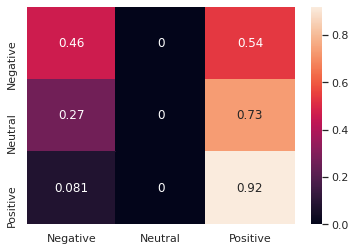

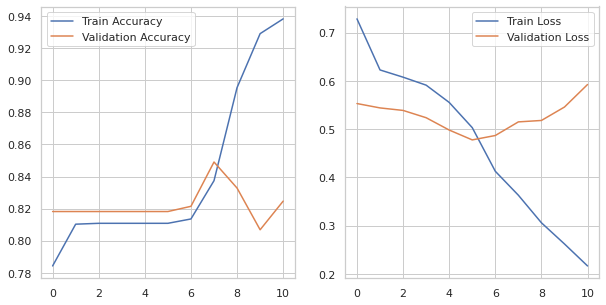

model validation accuracy is: 0.8246753246753247


In [20]:
model1 = KerasClassifier(build_fn = make_model1, 
                           epochs = 11, 
                           batch_size = 50, 
                           validation_data = (X_val,y_val))

history = model1.fit(X_t, y_t)
y_pred = model1.predict(X_val)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val,y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val,y_pred)}')

### Model 1 Evaluation
Model 1 overfits after 11 epochs.  It reaches 67% accuracy on the validation set at the point.  It struggles to classify negative emotions, and to a lesser degree positives.  Because of the class imbalance skewed toward no emotion, it overpredicts this class.

## Model 2
for model 2 I will try the same as model 1, but with SMOTED class balances.

In [21]:
def make_model2():
    embedding_size = 128
    model = Sequential()
    model.add(Embedding(len(tokenizer.word_index.keys())+1, sequence_len))
    model.add(LSTM(25, return_sequences=True))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

Epoch 1/20
90/90 [==============================] - 1s 16ms/step - loss: 1.0943 - acc: 0.3598 - val_loss: 1.0461 - val_acc: 0.7419
Epoch 2/20
90/90 [==============================] - 1s 12ms/step - loss: 1.0471 - acc: 0.4657 - val_loss: 0.9334 - val_acc: 0.6510
Epoch 3/20
90/90 [==============================] - 1s 11ms/step - loss: 0.9522 - acc: 0.5350 - val_loss: 1.0162 - val_acc: 0.5828
Epoch 4/20
90/90 [==============================] - 1s 11ms/step - loss: 0.8898 - acc: 0.5738 - val_loss: 0.7982 - val_acc: 0.7354
Epoch 5/20
90/90 [==============================] - 1s 12ms/step - loss: 0.8176 - acc: 0.6368 - val_loss: 0.7911 - val_acc: 0.7435
Epoch 6/20
90/90 [==============================] - 1s 12ms/step - loss: 0.7433 - acc: 0.6874 - val_loss: 1.1870 - val_acc: 0.5925
Epoch 7/20
90/90 [==============================] - 1s 11ms/step - loss: 0.6608 - acc: 0.7333 - val_loss: 0.7667 - val_acc: 0.7435
Epoch 8/20
90/90 [==============================] - 1s 11ms/step - loss: 0.6035 - a

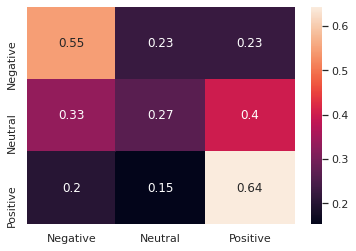

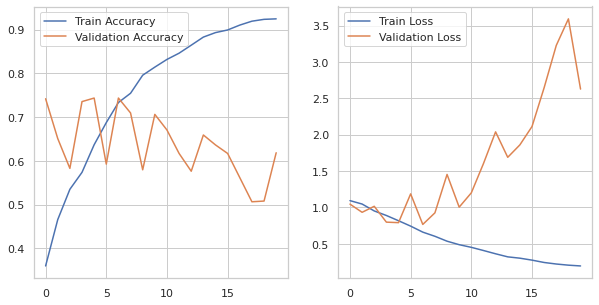

model validation accuracy is: 0.6185064935064936


In [22]:
model2 = KerasClassifier(build_fn = make_model2, 
                         epochs = 20, 
                         batch_size = 50, 
                         validation_data = (X_val,y_val))
history = model2.fit(X_t_res, y_t_res)
y_pred = model2.predict(X_val)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val,y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val,y_pred)}')

### Model 2 Evaluation:
Model 2 begins overfitting at about 6 epochs.  The overall accuracy is lower, but the true positive rates are more balanced between the classes.  False positives are still high for no emotion

# Model 3
In this model we will try using GloVe embeddings instead of a learned embedding layer
Relying heavily on fchollet at https://keras.io/examples/nlp/pretrained_word_embeddings/

In [23]:
import tensorflow as tf

### New Train test split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.25)
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state = 42, test_size = 0.25)



### Initialize the vectorizor, create the vocabulary, and create the word index

In [25]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=50)
text_ds = tf.data.Dataset.from_tensor_slices(X)
vectorizer.adapt(text_ds)
total_vocabulary = set(vectorizer.get_vocabulary())

len(total_vocabulary)
word_index = dict(zip(total_vocabulary, range(len(total_vocabulary))))

### Get pretrained embeddings from the GloVe model.

In [26]:
from gensim.models import word2vec

glove = {}
with open('/content/drive/My Drive/Colab Notebooks/flatiron_project_4/glove.6B/glove.6B.50d.txt',
          'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype = np.float32)
            glove[word] = vector
glove['school']

array([-0.90629  ,  1.2485   , -0.79692  , -1.4027   , -0.038458 ,
       -0.25177  , -1.2838   , -0.58413  , -0.11179  , -0.56908  ,
       -0.34842  , -0.39626  , -0.0090178, -1.0691   , -0.35368  ,
       -0.052826 , -0.37056  ,  1.0931   , -0.19205  ,  0.44648  ,
        0.45169  ,  0.72104  , -0.61103  ,  0.6315   , -0.49044  ,
       -1.7517   ,  0.055979 , -0.52281  , -1.0248   , -0.89142  ,
        3.0695   ,  0.14483  , -0.13938  , -1.3907   ,  1.2123   ,
        0.40173  ,  0.4171   ,  0.27364  ,  0.98673  ,  0.027599 ,
       -0.8724   , -0.51648  , -0.30662  ,  0.37784  ,  0.016734 ,
        0.23813  ,  0.49411  , -0.56643  , -0.18744  ,  0.62809  ],
      dtype=float32)

### Create the embedding matrix to act as the weights for the new embedding layer

In [31]:
num_tokens = len(total_vocabulary) + 2
embedding_dim = 50
hits = 0
misses = 0

embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits +=1
    else:
        misses += 1
print(f'converted {hits} words ({misses} misses)')
    

converted 3803 words (1239 misses)


revectorize the data for use with the custom embedding layer with the trained Vectorizer.

In [32]:
X_t_glove = vectorizer(np.array([[s] for s in X_t])).numpy()
X_val_glove = vectorizer(np.array([[s] for s in X_val])).numpy()
X_test_glove = vectorizer(np.array([[s] for s in X_test])).numpy()

X_t_glove_res, y_t_res = sm.fit_sample(X_t_glove,y_t)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [33]:
def make_model3():
    from tensorflow.keras import regularizers

    model = Sequential()

    embedding_layer = layers.Embedding(
                        num_tokens,
                        embedding_dim,
                        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                        trainable = True
                                )
    model.add(embedding_layer)
    model.add(LSTM(50, 
                   return_sequences=True
                   ))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='relu', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-4)))    
    model.add(Dropout(0.5))
 
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'rmsprop', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

### Train the model

Epoch 1/100
90/90 [==============================] - 1s 14ms/step - loss: 1.1460 - acc: 0.3387 - val_loss: 1.1398 - val_acc: 0.2727
Epoch 2/100
90/90 [==============================] - 1s 9ms/step - loss: 1.1351 - acc: 0.3523 - val_loss: 1.1012 - val_acc: 0.8182
Epoch 3/100
90/90 [==============================] - 1s 9ms/step - loss: 1.1030 - acc: 0.4153 - val_loss: 1.0157 - val_acc: 0.8101
Epoch 4/100
90/90 [==============================] - 1s 9ms/step - loss: 1.0551 - acc: 0.4594 - val_loss: 0.9020 - val_acc: 0.8101
Epoch 5/100
90/90 [==============================] - 1s 9ms/step - loss: 0.9958 - acc: 0.5007 - val_loss: 0.8111 - val_acc: 0.8052
Epoch 6/100
90/90 [==============================] - 1s 9ms/step - loss: 0.9522 - acc: 0.5261 - val_loss: 0.7876 - val_acc: 0.7841
Epoch 7/100
90/90 [==============================] - 1s 9ms/step - loss: 0.9322 - acc: 0.5390 - val_loss: 0.7311 - val_acc: 0.8117
Epoch 8/100
90/90 [==============================] - 1s 9ms/step - loss: 0.9123 - 

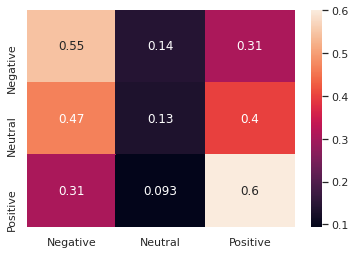

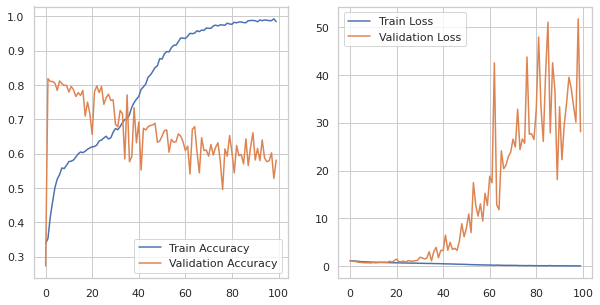

model validation accuracy is: 0.5811688311688312


In [35]:
import keras

model3 = make_model3()
history = model3.fit(X_t_glove_res, y_t_res, 
                     epochs = 100, 
                     batch_size = 50, 
                     validation_data = (X_val_glove, y_val)
                     )
y_pred = model3.predict(X_val_glove)
y_pred = np.argmax(y_pred, axis = 1).reshape(-1,1)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val, y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val, y_pred)}')

## Model 3 Evaluation:
Model 3 used pretrained weights from the GloVe embedding model to initialize it's embedding layer weights, but also allowed them to be further trained.  It overfit on the training data and achieved  50% accuracy.  However, it's errors were distributed across classes, rather than the model just guessing that all responses are positive.  I actually see this as an improvement.  I believe that the model needs more data, and more balanced data to make further significant progress.

### Model 4 
with this model we will explore tuning reguarlization to improve validation prediction success.

Epoch 1/50
90/90 [==============================] - 1s 16ms/step - loss: 1.5485 - acc: 0.3367 - val_loss: 1.3925 - val_acc: 0.0990
Epoch 2/50
90/90 [==============================] - 1s 11ms/step - loss: 1.4227 - acc: 0.3313 - val_loss: 1.3600 - val_acc: 0.2403
Epoch 3/50
90/90 [==============================] - 1s 11ms/step - loss: 1.3664 - acc: 0.3480 - val_loss: 1.3114 - val_acc: 0.5990
Epoch 4/50
90/90 [==============================] - 1s 10ms/step - loss: 1.3336 - acc: 0.3741 - val_loss: 1.2452 - val_acc: 0.6997
Epoch 5/50
90/90 [==============================] - 1s 10ms/step - loss: 1.2545 - acc: 0.4381 - val_loss: 1.0559 - val_acc: 0.7224
Epoch 6/50
90/90 [==============================] - 1s 10ms/step - loss: 1.1859 - acc: 0.4991 - val_loss: 0.8920 - val_acc: 0.7825
Epoch 7/50
90/90 [==============================] - 1s 10ms/step - loss: 1.1334 - acc: 0.5167 - val_loss: 0.9773 - val_acc: 0.7500
Epoch 8/50
90/90 [==============================] - 1s 10ms/step - loss: 1.0682 - a

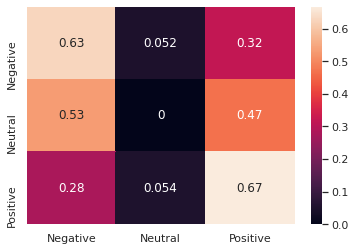

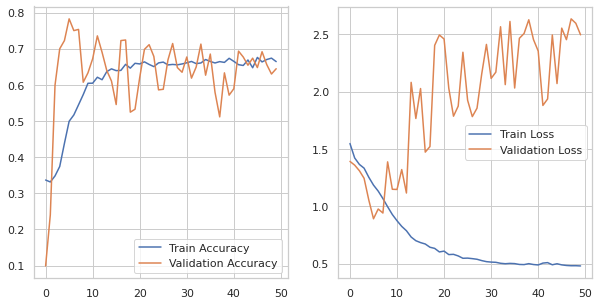

model validation accuracy is: 0.6444805194805194


In [37]:
def make_model4():
    from tensorflow.keras import regularizers

    model = Sequential()

    embedding_layer = layers.Embedding(
                        num_tokens,
                        embedding_dim,
                        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                        trainable = True
                                )
    model.add(embedding_layer)
    model.add(LSTM(75, 
                   return_sequences=True
                   ))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(0.5))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(0.6))

    model.add(Dense(64, activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(0.6))
 
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model

model4 = make_model4()
history = model4.fit(X_t_glove_res, y_t_res, 
                     epochs = 50, 
                     batch_size = 50, 
                     validation_data = (X_val_glove, y_val)
                     )
y_pred = model4.predict(X_val_glove)
y_pred = np.argmax(y_pred, axis = 1).reshape(-1,1)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val, y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val, y_pred)}')

### Model evaluation
Model is predicting positive and negative emotions with some reasonable success.  It does not seem to predict very many samples to be neutral however.  This is likely due a lack of data and class imbalance, but may also be a function of continued bias.  The validation accuracy and training accuracy converged at the end of training, which is great for the overfitting problem, though the losses diverged.  I believe this is because of the class imbalance in the validation set, and the generally small set of data that we have ended up with after dropping so many samples.

Next I will try Hypertuning to determine optimal hyperparameters for this model.


In [ ]:
!pip install -q -U keras-tuner
import kerastuner as kt

## Model 5
This model will be similar to model 4 initially, but I will try using kerastuner to do a gridsearch on hyperparameters.

In [51]:
def make_model5(hp):
    from tensorflow.keras import regularizers

    model = Sequential()



    embedding_layer = layers.Embedding(
                        num_tokens,
                        embedding_dim,
                        embeddings_initializer = keras.initializers.Constant(embedding_matrix),
                        trainable = hp.Choice([True,False])
                                )
    model.add(embedding_layer)
    model.add(LSTM(units = hp.Int('units', min_value = 20, max_value = 100, step = 20), 
                   return_sequences=True
                   ))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('units', min_value = 20, max_value = 100, step = 20), 
                    activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('units', min_value = 20, max_value = 100, step = 20), 
                    activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))    
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('units', min_value = 20, max_value = 100, step = 20), 
                    activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))   
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))

    model.add(Dense(units = hp.Int('units', min_value = 20, max_value = 100, step = 20), 
                    activation='tanh', 
                    kernel_regularizer = regularizers.l1_l2(l1=1e-5, l2=1e-3)))   
    model.add(Dropout(rate = hp.Float('rate', min_value = .3, max_value = .8, step = .1)))
 
    model.add(Dense(3, activation='softmax'))

    model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['acc'])

    return model



In [54]:
import IPython
class ClearTrainingOutput(tensorflow.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [ ]:
tuner = kt.Hyperband(make_model5,
                     objective = 'val_acc',
                     max_epochs = 100,
                     factor = 10,
                     directory = '/content/drive/My Drive/Colab Notebooks/flatiron_project_4',
                     project_name = 'NLP_phase_4_flatiron')


tuner.search(X_t_glove_res, y_t_res, epochs = 10, validation_data = (X_val_glove, y_val), callbacks = [ClearTrainingOutput()])


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials = 10)[0]
best_hps.get('units')
model5 = tuner.hypermodel.build(best_hps)
history = model5.fit(X_t_glove_res, y_t_res, 
                     epochs = 11, 
                     batch_size = 50, 
                     validation_data = (X_val_glove, y_val)
                     )
y_pred = model5.predict(X_val_glove)
y_pred = np.argmax(y_pred, axis = 1).reshape(-1,1)
print('Statistics for Model1, LSTM')
plot_confusion_matrix(y_val, y_pred)
graph_model_history(history)
print(f'model validation accuracy is: {accuracy_score(y_val, y_pred)}')